<p style="text-align: center; font-size: 300%"> Computational Finance </p>
<img src="img/ABSlogo.svg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">

# Risk Measures

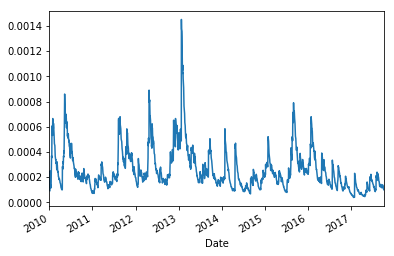

In [8]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web 
start = pd.datetime(2010, 1, 1)
end = pd.datetime.today()
aapl = web.DataReader("AAPL", 'yahoo', start, end)
ret=np.log(aapl['Adj Close'])-np.log(aapl['Adj Close']).shift(1);
sig=ret.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.06).var(bias=False)
import matplotlib.pyplot as plt
%matplotlib inline
sig.plot()


# Plotting